# Calibration methods comparison: simulated predictions on 2-simplex

In [1]:
%load_ext autoreload

In [2]:
%autoreload 1

In [3]:
import os
import sys
import time
import random
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
from sklearn.isotonic import IsotonicRegression

import torch

%aimport utils
%aimport utils.ops
%aimport utils.metrics
%aimport utils.visualization
%aimport flows.normalizing_flows_torch
%aimport calibrators
from utils.ops import onehot_encode, optim_temperature, detection_log_likelihood_ratios
from utils.metrics import neg_log_likelihood, expected_calibration_error
from utils.visualization import plot_pdf_simplex, plot_prob_simplex, reliability_plot, reliability_diagram, ECE_plot, plot_cal_regions_ternary
from flows.normalizing_flows_torch import PlanarFlow, RadialFlow, AffineConstantFlow
from flows.nice_torch import NiceFlow
from flows.realNVP_torch import RealNvpFlow
from calibrators import PAVCalibrator, MLRCalibrator, TempScalingCalibrator, TorchFlowCalibrator

In [4]:
# Select Device to use
device = torch.device("cpu")

In [5]:
%matplotlib inline
np.random.seed(2)

### Generate fake target distribution and simulated predictions

In [ ]:
n_samples = 1500

target = np.array(random.choices(range(3), k=n_samples))
one_hot = onehot_encode(target)

# Shift
offset = np.zeros((n_samples, 3))
offset[:, 1:] = 0.3

# Twist
twisting = np.zeros((n_samples, 3))
twisting[np.arange(n_samples), target-1] = 0.7 + np.random.randn(n_samples)*0.1

snt_logits = np.float32(0.8 * (one_hot + twisting + np.random.randn(n_samples, 3)*0.3) + offset)

# 0-center logits
snt_logits -= np.mean(snt_logits, axis=1, keepdims=True)

snt_probs = softmax(snt_logits, axis=1)

nll = neg_log_likelihood(snt_probs, target)
ECE = expected_calibration_error(snt_probs, target)

print("Negative log-likelihood of the classifier predictions: {:.5f}".format(nll))
print("Expected Calibration Error of the classifier predictions: {:.5f}".format(ECE))

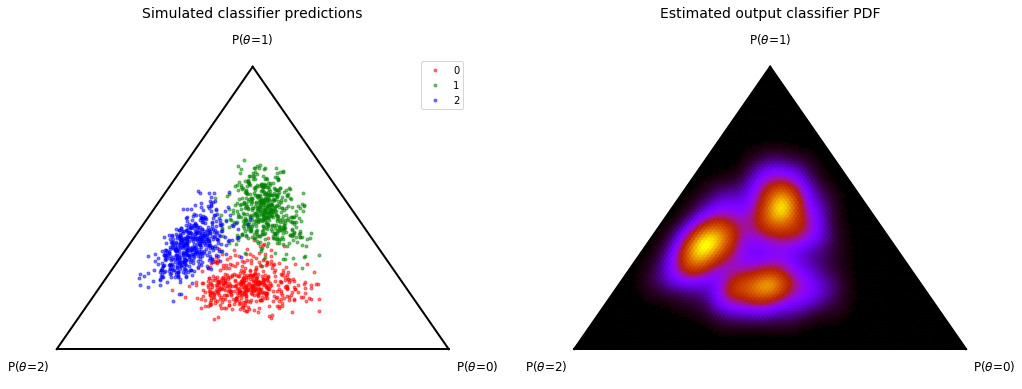

In [7]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6))
ax_arr[0] = plot_prob_simplex(snt_probs, target=target, ax=ax_arr[0], title='Simulated classifier predictions', fontsize=12);
ax_arr[1] = plot_pdf_simplex(snt_probs, scale=100, ax=ax_arr[1], title='Estimated output classifier PDF', fontsize=12);
plt.show()

## Fit calibrators

Fitted RealNVP in 188.335s
Fitted NICE in 160.681s
Fitted PlanarFlow in 136.826s
Fitted RadialFlow in 170.300s


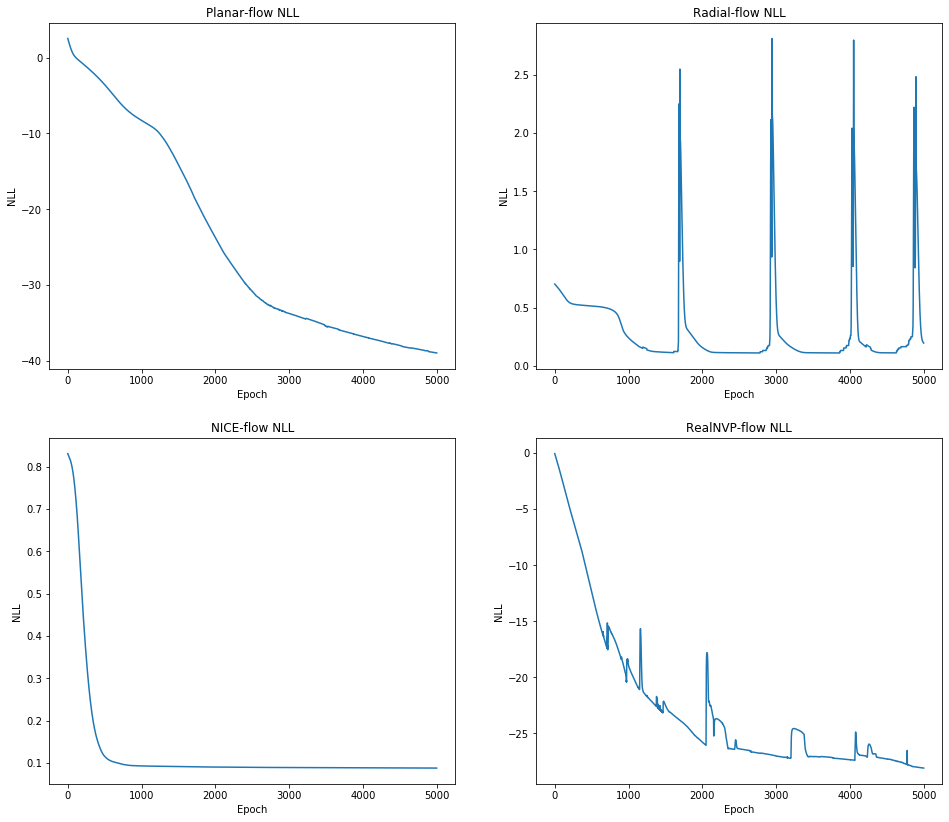

In [8]:
epochs = 5000


## Temp-Scaling
temp_cal = TempScalingCalibrator(snt_logits, target)
temp_probs = temp_cal.predict(snt_logits)

nll_temp = neg_log_likelihood(temp_probs, target)
ECE_temp = expected_calibration_error(temp_probs, target)


## Multiclass PAV
pav_cal = PAVCalibrator(snt_logits, target)
pav_probs = pav_cal.predict(snt_logits)

nll_pav = neg_log_likelihood(pav_probs, target)
ECE_pav = expected_calibration_error(pav_probs, target)


## MLR
mlr_cal = MLRCalibrator(snt_logits, target)
mlr_probs = mlr_cal.predict(snt_logits)

nll_mlr = neg_log_likelihood(mlr_probs, target)
ECE_mlr = expected_calibration_error(mlr_probs, target)


## RealNVP flow
t0 = time.time()
nvp_cal = TorchFlowCalibrator(RealNvpFlow, snt_logits, target, layers=5, hidden_size=[3, 3], dev=device, epochs=epochs)
print('Fitted RealNVP in {:.3f}s'.format(time.time()-t0))
nvp_probs = nvp_cal.predict(snt_logits)

nll_nvp = neg_log_likelihood(nvp_probs, target)
ECE_nvp = expected_calibration_error(nvp_probs, target)


## NICE flow
t0 = time.time()
nice_cal = TorchFlowCalibrator(NiceFlow, snt_logits, target, layers=5, hidden_size=[3, 3], dev=device, epochs=epochs)
print('Fitted NICE in {:.3f}s'.format(time.time()-t0))
nice_probs = nice_cal.predict(snt_logits)

nll_nice = neg_log_likelihood(nice_probs, target)
ECE_nice = expected_calibration_error(nice_probs, target)


## Planar flow
t0 = time.time()
pln_cal = TorchFlowCalibrator(PlanarFlow, snt_logits, target, layers=5, dev=device, epochs=epochs)
print('Fitted PlanarFlow in {:.3f}s'.format(time.time()-t0))
pln_probs = pln_cal.predict(snt_logits)

nll_pln = neg_log_likelihood(pln_probs, target)
ECE_pln = expected_calibration_error(pln_probs, target)


## Radial flow
t0 = time.time()
rdl_cal = TorchFlowCalibrator(RadialFlow, snt_logits, target, layers=5, dev=device, epochs=epochs)
print('Fitted RadialFlow in {:.3f}s'.format(time.time()-t0))
rdl_probs = rdl_cal.predict(snt_logits)

nll_rdl = neg_log_likelihood(rdl_probs, target)
ECE_rdl = expected_calibration_error(rdl_probs, target)


# Plot training NLL
fig, ax_arr = plt.subplots(2, 2, figsize=(16, 14))

ax_arr[0, 0].plot(pln_cal.history['loss'])
ax_arr[0, 0].set_title('Planar-flow NLL')
ax_arr[0, 0].set_ylabel('NLL')
ax_arr[0, 0].set_xlabel('Epoch')

ax_arr[0, 1].plot(rdl_cal.history['loss'])
ax_arr[0, 1].set_title('Radial-flow NLL')
ax_arr[0, 1].set_ylabel('NLL')
ax_arr[0, 1].set_xlabel('Epoch')

ax_arr[1, 0].plot(nice_cal.history['loss'])
ax_arr[1, 0].set_title('NICE-flow NLL')
ax_arr[1, 0].set_ylabel('NLL')
ax_arr[1, 0].set_xlabel('Epoch')

ax_arr[1, 1].plot(nvp_cal.history['loss'])
ax_arr[1, 1].set_title('RealNVP-flow NLL')
ax_arr[1, 1].set_ylabel('NLL')
ax_arr[1, 1].set_xlabel('Epoch')

plt.show()

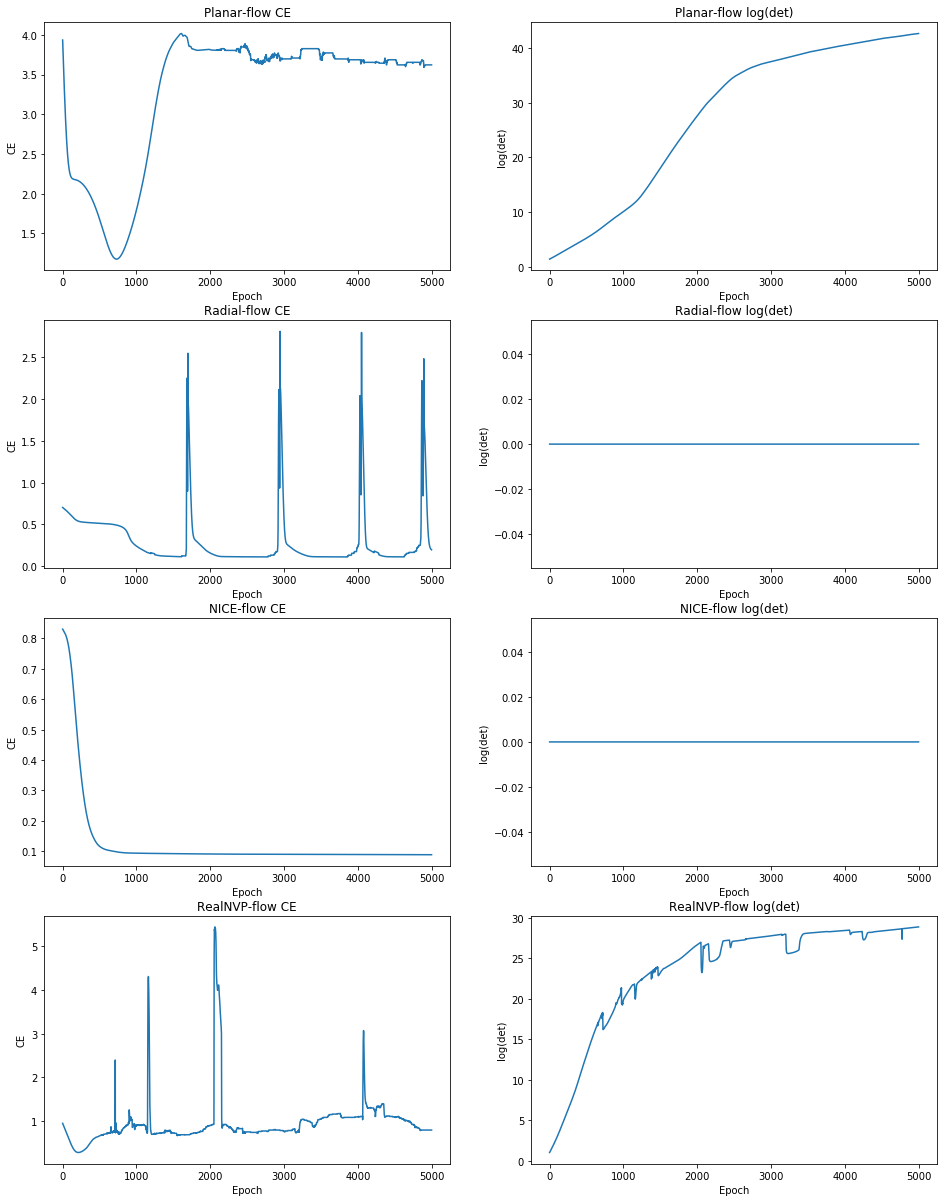

In [9]:
# Plot training CE and log(det)
fig, ax_arr = plt.subplots(4, 2, figsize=(16, 21))

ax_arr[0, 0].plot(pln_cal.history['ce'])
ax_arr[0, 0].set_title('Planar-flow CE')
ax_arr[0, 0].set_ylabel('CE')
ax_arr[0, 0].set_xlabel('Epoch')

ax_arr[0, 1].plot(pln_cal.history['log_det'])
ax_arr[0, 1].set_title('Planar-flow log(det)')
ax_arr[0, 1].set_ylabel('log(det)')
ax_arr[0, 1].set_xlabel('Epoch')

ax_arr[1, 0].plot(rdl_cal.history['ce'])
ax_arr[1, 0].set_title('Radial-flow CE')
ax_arr[1, 0].set_ylabel('CE')
ax_arr[1, 0].set_xlabel('Epoch')

ax_arr[1, 1].plot(rdl_cal.history['log_det'])
ax_arr[1, 1].set_title('Radial-flow log(det)')
ax_arr[1, 1].set_ylabel('log(det)')
ax_arr[1, 1].set_xlabel('Epoch')

ax_arr[2, 0].plot(nice_cal.history['ce'])
ax_arr[2, 0].set_title('NICE-flow CE')
ax_arr[2, 0].set_ylabel('CE')
ax_arr[2, 0].set_xlabel('Epoch')

ax_arr[2, 1].plot(nice_cal.history['log_det'])
ax_arr[2, 1].set_title('NICE-flow log(det)')
ax_arr[2, 1].set_ylabel('log(det)')
ax_arr[2, 1].set_xlabel('Epoch')

ax_arr[3, 0].plot(nvp_cal.history['ce'])
ax_arr[3, 0].set_title('RealNVP-flow CE')
ax_arr[3, 0].set_ylabel('CE')
ax_arr[3, 0].set_xlabel('Epoch')

ax_arr[3, 1].plot(nvp_cal.history['log_det'])
ax_arr[3, 1].set_title('RealNVP-flow log(det)')
ax_arr[3, 1].set_ylabel('log(det)')
ax_arr[3, 1].set_xlabel('Epoch')

plt.show()

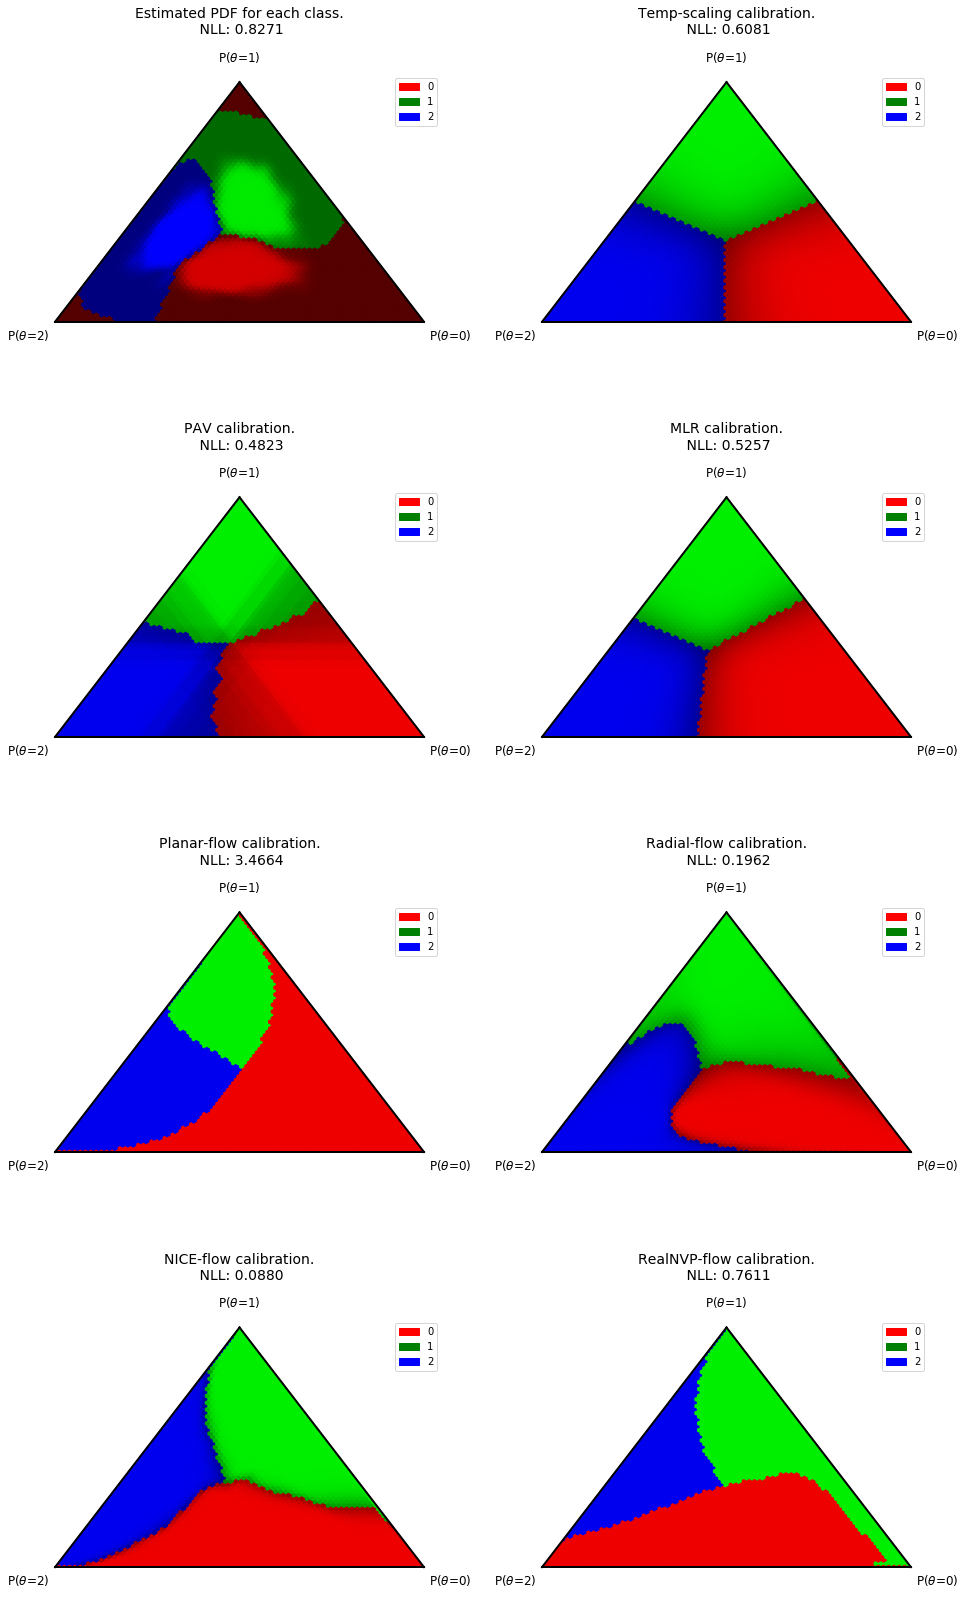

In [10]:
fig, ax_arr = plt.subplots(4, 2, figsize=(16, 28), gridspec_kw={'hspace': 0.5})

ax_arr[0, 0] = plot_pdf_simplex(snt_probs, target=target, ax=ax_arr[0, 0], scale=70,
                                title='Estimated PDF for each class.\n NLL: {:.4f}'.format(nll), fontsize=12);
ax_arr[0, 1] = plot_cal_regions_ternary(temp_cal, ax=ax_arr[0, 1], scale=70,
                             title='Temp-scaling calibration.\n NLL: {:.4f}'.format(nll_temp), fontsize=12);
ax_arr[1, 0] = plot_cal_regions_ternary(pav_cal, ax=ax_arr[1, 0], scale=70,
                             title='PAV calibration.\n NLL: {:.4f}'.format(nll_pav), fontsize=12);
ax_arr[1, 1] = plot_cal_regions_ternary(mlr_cal, ax=ax_arr[1, 1], scale=70,
                             title='MLR calibration.\n NLL: {:.4f}'.format(nll_mlr), fontsize=12);
ax_arr[2, 0] = plot_cal_regions_ternary(pln_cal, ax=ax_arr[2, 0], scale=70,
                             title='Planar-flow calibration.\n NLL: {:.4f}'.format(nll_pln), fontsize=12);
ax_arr[2, 1] = plot_cal_regions_ternary(rdl_cal, ax=ax_arr[2, 1], scale=70,
                             title='Radial-flow calibration.\n NLL: {:.4f}'.format(nll_rdl), fontsize=12);
ax_arr[3, 0] = plot_cal_regions_ternary(nice_cal, ax=ax_arr[3, 0], scale=70,
                             title='NICE-flow calibration.\n NLL: {:.4f}'.format(nll_nice), fontsize=12);
ax_arr[3, 1] = plot_cal_regions_ternary(nvp_cal, ax=ax_arr[3, 1], scale=70,
                             title='RealNVP-flow calibration.\n NLL: {:.4f}'.format(nll_nvp), fontsize=12);

plt.show()

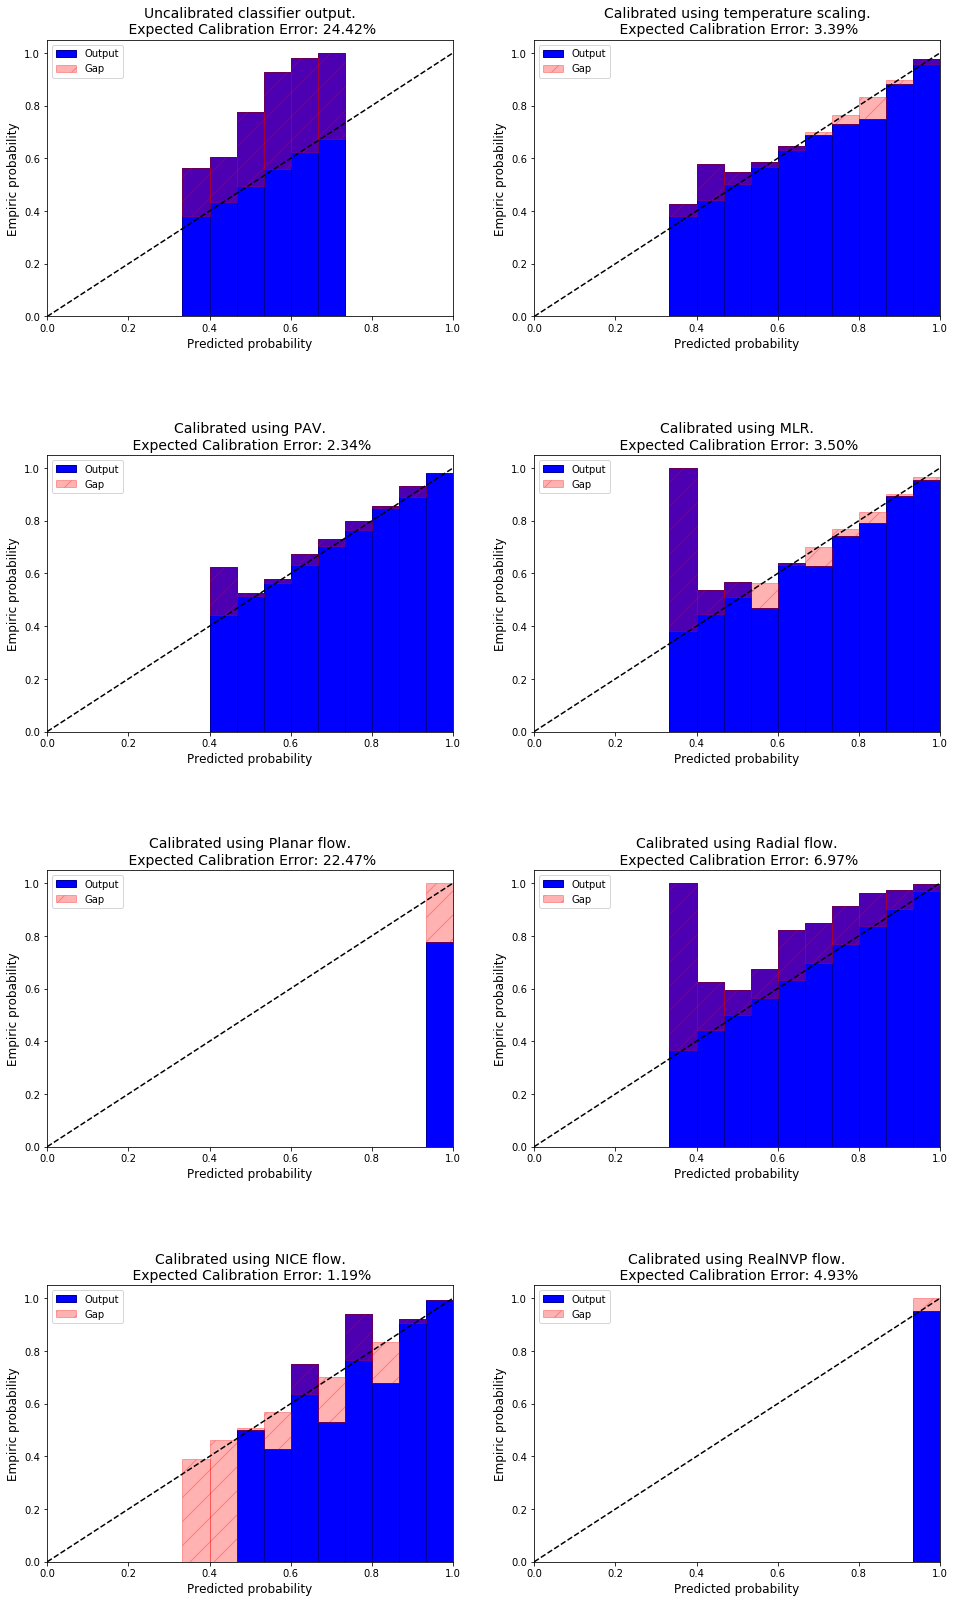

In [11]:
fig, ax_arr = plt.subplots(4, 2, figsize=(16, 28), gridspec_kw={'hspace': 0.5})
ax_arr[0, 0] = reliability_diagram(snt_probs, target, ax=ax_arr[0, 0],
                             title='Uncalibrated classifier output.\n Expected Calibration Error: {:.2%}'.format(ECE), fontsize=12);
ax_arr[0, 1] = reliability_diagram(temp_probs, target, ax=ax_arr[0, 1],
                             title='Calibrated using temperature scaling.\n Expected Calibration Error: {:.2%}'.format(ECE_temp), fontsize=12);
ax_arr[1, 0] = reliability_diagram(pav_probs, target, ax=ax_arr[1, 0],
                             title='Calibrated using PAV.\n Expected Calibration Error: {:.2%}'.format(ECE_pav), fontsize=12);
ax_arr[1, 1] = reliability_diagram(mlr_probs, target, ax=ax_arr[1, 1],
                             title='Calibrated using MLR.\n Expected Calibration Error: {:.2%}'.format(ECE_mlr), fontsize=12);
ax_arr[2, 0] = reliability_diagram(pln_probs, target, ax=ax_arr[2, 0],
                             title='Calibrated using Planar flow.\n Expected Calibration Error: {:.2%}'.format(ECE_pln), fontsize=12);
ax_arr[2, 1] = reliability_diagram(rdl_probs, target, ax=ax_arr[2, 1],
                             title='Calibrated using Radial flow.\n Expected Calibration Error: {:.2%}'.format(ECE_rdl), fontsize=12);
ax_arr[3, 0] = reliability_diagram(nice_probs, target, ax=ax_arr[3, 0],
                             title='Calibrated using NICE flow.\n Expected Calibration Error: {:.2%}'.format(ECE_nice), fontsize=12);
ax_arr[3, 1] = reliability_diagram(nvp_probs, target, ax=ax_arr[3, 1],
                             title='Calibrated using RealNVP flow.\n Expected Calibration Error: {:.2%}'.format(ECE_nvp), fontsize=12);

plt.show()

## Visualize 2-simplex after each Planar layer:

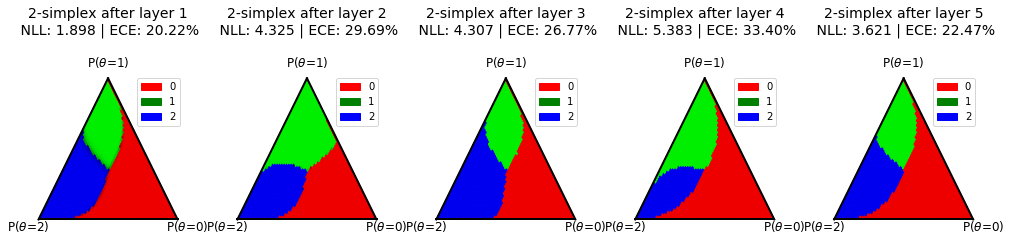

In [12]:
x = torch.as_tensor(snt_logits, dtype=torch.float)
    
fig, ax_arr = plt.subplots(1, 5, figsize=(17, 3), gridspec_kw={'hspace': 0.5, 'wspace': 0.3})
layers = []
for i, layer in enumerate(pln_cal.flow.layers):
    layers.append(layer)
    def model(x):
        x = torch.as_tensor(x, dtype=torch.float)
        for _layer in layers:
            x, _ = _layer(x)
        return softmax(x.cpu().detach().numpy(), axis=1)
    x, _ = layer(x)
    probs = softmax(x.cpu().detach().numpy(), axis=1)
    nll = neg_log_likelihood(probs, target)
    ECE = expected_calibration_error(probs, target)
    ax_arr[i] = plot_cal_regions_ternary(model, ax=ax_arr[i], scale=60,
                                         title='2-simplex after layer {}\n NLL: {:.3f} | ECE: {:.2%}'.format(i+1, nll, ECE),
                                         fontsize=12);
    
plt.show()

## Visualize 2-simplex after each Radial layer:

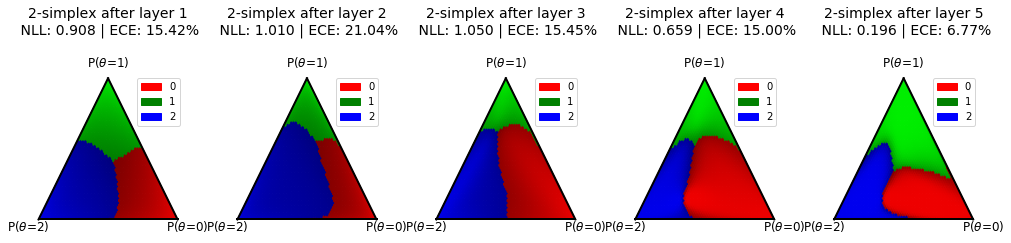

In [13]:
x = torch.as_tensor(snt_logits, dtype=torch.float)
    
fig, ax_arr = plt.subplots(1, 5, figsize=(17, 3), gridspec_kw={'hspace': 0.5, 'wspace': 0.3})
layers = []
for i, layer in enumerate(rdl_cal.flow.layers):
    layers.append(layer)
    def model(x):
        x = torch.as_tensor(x, dtype=torch.float)
        for _layer in layers:
            x, _ = _layer(x)
        return softmax(x.cpu().detach().numpy(), axis=1)
    x, _ = layer(x)
    probs = softmax(x.cpu().detach().numpy(), axis=1)
    nll = neg_log_likelihood(probs, target)
    ECE = expected_calibration_error(probs, target)
    ax_arr[i] = plot_cal_regions_ternary(model, ax=ax_arr[i], scale=60,
                                         title='2-simplex after layer {}\n NLL: {:.3f} | ECE: {:.2%}'.format(i+1, nll, ECE),
                                         fontsize=12);
    
plt.show()

## Visualize 2-simplex after each NICE layer:

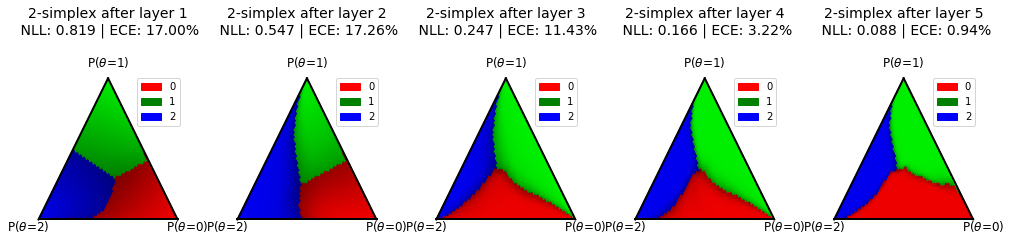

In [14]:
x = torch.as_tensor(snt_logits, dtype=torch.float)
    
fig, ax_arr = plt.subplots(1, 5, figsize=(17, 3), gridspec_kw={'hspace': 0.5, 'wspace': 0.3})
layers = []
for i, layer in enumerate(nice_cal.flow.layers):
    layers.append(layer)
    def model(x):
        x = torch.as_tensor(x, dtype=torch.float)
        for _layer in layers:
            x, _ = _layer(x)
        return softmax(x.cpu().detach().numpy(), axis=1)
    x, _ = layer(x)
    probs = softmax(x.cpu().detach().numpy(), axis=1)
    nll = neg_log_likelihood(probs, target)
    ECE = expected_calibration_error(probs, target)
    ax_arr[i] = plot_cal_regions_ternary(model, ax=ax_arr[i], scale=60,
                                         title='2-simplex after layer {}\n NLL: {:.3f} | ECE: {:.2%}'.format(i+1, nll, ECE),
                                         fontsize=12);
    
plt.show()

## Visualize 2-simplex after each RealNVP layer:

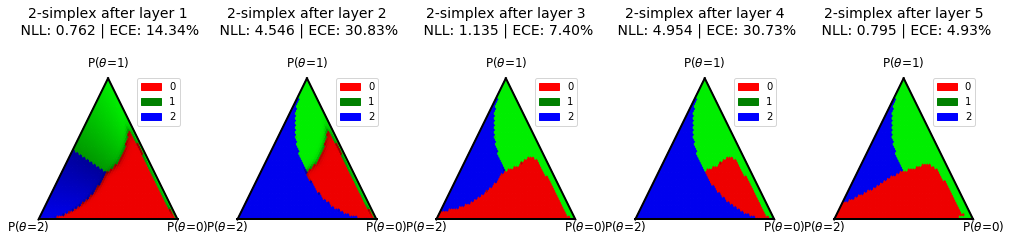

In [15]:
x = torch.as_tensor(snt_logits, dtype=torch.float)
    
fig, ax_arr = plt.subplots(1, 5, figsize=(17, 3), gridspec_kw={'hspace': 0.5, 'wspace': 0.3})
layers = []
for i, layer in enumerate(nvp_cal.flow.layers):
    layers.append(layer)
    def model(x):
        x = torch.as_tensor(x, dtype=torch.float)
        for _layer in layers:
            x, _ = _layer(x)
        return softmax(x.cpu().detach().numpy(), axis=1)
    x, _ = layer(x)
    probs = softmax(x.cpu().detach().numpy(), axis=1)
    nll = neg_log_likelihood(probs, target)
    ECE = expected_calibration_error(probs, target)
    ax_arr[i] = plot_cal_regions_ternary(model, ax=ax_arr[i], scale=60,
                                         title='2-simplex after layer {}\n NLL: {:.3f} | ECE: {:.2%}'.format(i+1, nll, ECE),
                                         fontsize=12);
    
plt.show()

In [16]:
1 - nvp_cal.flow.layers[2].mask

tensor([[1., 0., 0.]])

In [17]:
nice_cal.flow.layers[2].coupling_func.layers[0].weight

Parameter containing:
tensor([[-0.0406, -0.8865,  0.4862],
        [-0.7287,  0.9650, -0.9981],
        [-0.4804,  1.8879,  0.3760]], requires_grad=True)

In [25]:
pln_cal.flow.layers[3].t

Parameter containing:
tensor([[ 1.2167, -1.8834, -1.7272]], requires_grad=True)